In [1]:
from __future__ import division, print_function, absolute_import

import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import h5py
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

%matplotlib inline

In [2]:
IMG_WIDTH = 32 # Side for each transformed Image
IMG_HEIGHT = 32
IMG_DEPTH = 1 # RGB files

In [3]:
NUM_LABELS = 3
h5FileName = 'svhn_' + str(NUM_LABELS) + '.h5'

In [4]:
data = h5py.File(h5FileName)
imgs = np.array(data['images']).astype(float)
labels = np.array(data['digits'])

In [5]:
print (type(imgs))
print (labels.shape)
print (imgs.shape)

<type 'numpy.ndarray'>
(106789, 3)
(106789, 32, 32)


[2 7 0]


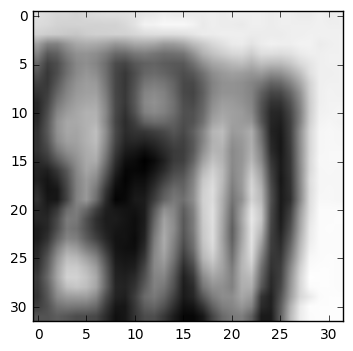

In [6]:
print (labels[0])
plt.imshow(imgs[0], cmap='gray')

In [7]:
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    index_update = [int(x) for x in index_offset + labels_dense.ravel()]
    labels_one_hot.flat[index_update] = 1
    return labels_one_hot

In [8]:
# Get the dataset
X = imgs.reshape([-1, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH])
Y = labels

In [9]:
# Generate validation set
ratio = 0.9 # Train/Test set
randIdx = np.random.random(imgs.shape[0]) <= ratio
#print (sum(map(lambda x: int(x), randIdx)))
X_train = X[randIdx]
Y_train = Y[randIdx]
X_test = X[randIdx == False]
Y_test = Y[randIdx == False]
Y_train = [dense_to_one_hot(Y_train[:,idx], num_classes= 10) for idx in range(Y_train.shape[1])] 
Y_test = [dense_to_one_hot(Y_test[:,idx], num_classes= 10) for idx in range(Y_test.shape[1])] 
#del X, Y # release some space

In [10]:
print (X_train.shape)
print (Y_train[0].shape)

(96346, 32, 32, 1)
(96346, 10)


In [18]:
print (np.mean(Y_train[1], axis = 0))

[ 0.12520499  0.12039939  0.11598821  0.10640815  0.09799058  0.09874826
  0.08505802  0.09683848  0.07833226  0.07503166]


In [ ]:
# Building convolutional network

with tf.Graph().as_default():
   # Building convolutional network
    # Real-time data preprocessing
    img_prep = ImagePreprocessing()
    img_prep.add_featurewise_zero_center()
    img_prep.add_featurewise_stdnorm()

    # Real-time data augmentation
    img_aug = ImageAugmentation()
    #img_aug.add_random_flip_leftright()
    img_aug.add_random_rotation(max_angle=25.)
    network = input_data(shape=[None, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH], name='input',
                                             data_preprocessing=img_prep,
                                             data_augmentation=img_aug)
    network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
    network = max_pool_2d(network, 2)
    network = local_response_normalization(network)
    network = conv_2d(network, 64, 3, activation='relu', regularizer="L2")
    network = max_pool_2d(network, 2)
    network = local_response_normalization(network)
    #network = fully_connected(network, 1024, activation='tanh')
    #network = dropout(network, 0.8)
    #network = fully_connected(network, 1024, activation='tanh')
    #network = dropout(network, 0.8)
    fc_1 = fully_connected(network, 1024, activation='tanh')
    #fc_1 = dropout(fc_1, 0.8)
    fc_2 = fully_connected(network, 1024, activation='tanh')
    #fc_2 = dropout(fc_2, 0.8)
    fc_3 = fully_connected(network, 1024, activation='tanh')
    #fc_3 = dropout(fc_3, 0.8)
    softmax1 = fully_connected(fc_1, 10, activation='softmax')
    softmax2 = fully_connected(fc_2, 10, activation='softmax')
    softmax3 = fully_connected(fc_3, 10, activation='softmax')
    #softmax1 = fully_connected(network, 10, activation='softmax')
    #softmax2 = fully_connected(network, 10, activation='softmax')
    #softmax3 = fully_connected(network, 10, activation='softmax')
    network1 = regression(softmax1, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy', name='target0')
    network2 = regression(softmax2, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy', name='target1')
    network3 = regression(softmax3, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy', name='target2')
    network = tflearn.merge([network1, network2, network3], mode='elemwise_sum')

    model = tflearn.DNN(network, tensorboard_verbose=3)
    feedTrainDict = {'target'+ str(i): Y_train[i] for i in range(NUM_LABELS)}
    #feedTrainDict = {'target0': Y_train[0]}
    feedTestList =  [Y_test[i] for i in range(NUM_LABELS)]
    #feedTestList =  Y_test[0]
    model.fit({'input': X_train}, feedTrainDict, 
              validation_set= (X_test, feedTestList), n_epoch=1, snapshot_step=100, show_metric=True, run_id='convnet_svhn')
    #model.fit({'input': X_train}, feedTrainDict, n_epoch=1, show_metric=True, run_id='convnet_mnist')
    #model.fit({'input': X_train}, {'target0': Y_train[1]}, n_epoch=1, show_metric=True, run_id='convnet_mnist')
    numImgEachAxis = 8
    f,ax = plt.subplots(numImgEachAxis, numImgEachAxis, figsize=(10,10))
    for i in range(numImgEachAxis):
        for j in range(numImgEachAxis):
            res = np.argmax(model.predict([X_train[i*numImgEachAxis + j]]))
            print (str(i) + ',' + str(j) + ' -> ' +str(res))
            #ax[i][j].set_title(str([np.round(x,2) for x in res]))
            ax[i][j].imshow(X_train[i*numImgEachAxis + j].reshape((IMG_HEIGHT,IMG_WIDTH)) ,cmap = 'gray')
    plt.show() # or display.display(plt.gcf()) if you prefer
#    print (model.evaluate(X_test,feedTestList))

Training Step: 77  | total loss: 5.55888
| Adam_0 | epoch: 000 | loss: 1.52289 - acc: 0.4764 -- iter: 04928/96346
| Adam_1 | epoch: 000 | loss: 1.96117 - acc: 0.3302 -- iter: 04928/96346
| Adam | epoch: 000 | loss: 2.07482 - acc: 0.2473 -- iter: 04928/96346
